In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from PIL import Image

from diffusers import StableDiffusionXLPipeline
from diffusers import DPMSolverMultistepScheduler
from diffusers import DDIMScheduler
from diffusers.schedulers import AysSchedules

import gc
import inspect
import PIL

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from diffusers.image_processor import PipelineImageInput, VaeImageProcessor
from diffusers.callbacks import MultiPipelineCallbacks, PipelineCallback
from diffusers.pipelines.stable_diffusion_xl.pipeline_stable_diffusion_xl import StableDiffusionXLPipelineOutput
from diffusers.pipelines.stable_diffusion_xl.pipeline_stable_diffusion_xl import retrieve_timesteps

# Dependencies

The code was tested with following libraries
 - torch==2.4.0 
 - diffusers==0.30.1
 - transformers==4.45.2
 - numpy==2.0.2
 - pillow==10.4.0

In [2]:
def print_images(pil_imgs, with_density=False, points=200, titles=None, s=10):
    fig = plt.figure(figsize=(13, 10))
    n = len(pil_imgs)
    azim = 236 #np.random.uniform(0,360)
    nrows = 2 if with_density else 1
    for i in range(n):
        img = pil_imgs[i]
        ax = fig.add_subplot(nrows, n, i+1)
        ax.imshow(img)
        if titles is not None:
            ax.set_title(titles[i])
        ax.axis('off')
        
        if with_density:
            img = img.convert('RGB')
            w, h = img.size
            arr = np.array(img).reshape(w*h, 3) / 255
            idx = np.random.permutation(w*h)[:points]
            
            ax = fig.add_subplot(nrows, n, n+i+1, projection='3d')
            r = arr[idx, 0]
            g = arr[idx, 1]
            b = arr[idx, 2]
            ax.scatter(r, g, b, c=arr[idx, :], alpha=0.5, s=s)
            ax.view_init(elev=30, azim=azim)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_zlim(0, 1)
            ax.axes.get_xaxis().set_ticklabels([])
            ax.axes.get_yaxis().set_ticklabels([])
            ax.axes.get_zaxis().set_ticklabels([])
    return fig


def decode_to_image(latent_aux, vae):
    with torch.no_grad():
        image = vae.decode(1 / 0.18215 * latent_aux).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    images =  Image.fromarray(images[0])
    gc.collect()
    torch.cuda.empty_cache()
    return images


def rand_rotation_matrix(deflection=1.0, randnums=None):
    """
    Creates a random rotation matrix.
    
    deflection: the magnitude of the rotation. For 0, no rotation; for 1, competely random
    rotation. Small deflection => small perturbation.
    randnums: 3 random numbers in the range [0, 1]. If `None`, they will be auto-generated.
    """
    # from http://www.realtimerendering.com/resources/GraphicsGems/gemsiii/rand_rotation.c
    
    if randnums is None:
        randnums = np.random.uniform(size=(3,))
        
    theta, phi, z = randnums
    
    theta = theta * 2.0*deflection*np.pi  # Rotation about the pole (Z).
    phi = phi * 2.0*np.pi  # For direction of pole deflection.
    z = z * 2.0*deflection  # For magnitude of pole deflection.
    
    # Compute a vector V used for distributing points over the sphere
    # via the reflection I - V Transpose(V).  This formulation of V
    # will guarantee that if x[1] and x[2] are uniformly distributed,
    # the reflected points will be uniform on the sphere.  Note that V
    # has length sqrt(2) to eliminate the 2 in the Householder matrix.
    
    r = np.sqrt(z)
    Vx, Vy, Vz = V = (
        np.sin(phi) * r,
        np.cos(phi) * r,
        np.sqrt(2.0 - z)
        )
    
    st = np.sin(theta)
    ct = np.cos(theta)
    R = np.array(((ct, st, 0), (-st, ct, 0), (0, 0, 1)))
    
    # Construct the rotation matrix  ( V Transpose(V) - I ) R.
    M = (np.outer(V, V) - np.eye(3)).dot(R)
    return M


def sigmoid(x):
    return 1 - 1 / (1 + torch.exp(-35*x))


def get_cdf(x_samples, full_range):
    return sigmoid((x_samples[:,None]-full_range[None,:])).sum(0)/len(x_samples)  


def sliced_wasserstein(loss, pixels_gen, pixels_ref, num_slices=10, use_differenatable_historgam_matching=False):
        for slice_idx in range(num_slices):
            R_trans = rand_rotation_matrix(deflection=1.0)
            R_trans = torch.Tensor(R_trans)
            R_trans = R_trans.to(device).to(torch.bfloat16)
            pixels_gen_rotated = pixels_gen.T@R_trans
            pixels_ref_rotated = pixels_ref.T@R_trans
            for dim_idx in range(3):
                x_samples_3d_rotated_slice = pixels_gen_rotated[:,dim_idx]
                y_samples_3d_rotated_slice = pixels_ref_rotated[:,dim_idx]

                if not use_differenatable_historgam_matching:
                    rand_idxes_len = min(len(x_samples_3d_rotated_slice), len(y_samples_3d_rotated_slice))
                    rand_idxes = np.random.randint(0, rand_idxes_len, rand_idxes_len)
                    x_samples_3d_rotated_slice = x_samples_3d_rotated_slice[rand_idxes]
                    y_samples_3d_rotated_slice = y_samples_3d_rotated_slice[rand_idxes]

                    x_samples_3d_rotated_slice = torch.sort(x_samples_3d_rotated_slice).values
                    y_samples_3d_rotated_slice = torch.sort(y_samples_3d_rotated_slice).values
                    loss += torch.mean(torch.abs(x_samples_3d_rotated_slice-y_samples_3d_rotated_slice))
                else:
                    min_range = min(
                        x_samples_3d_rotated_slice.min().item(),
                        y_samples_3d_rotated_slice.min().item()
                    )
                    max_range = max(
                        x_samples_3d_rotated_slice.max().item(),
                        y_samples_3d_rotated_slice.max().item()
                    )
                    grid_size = 400
                    full_range = torch.linspace(min_range-0.05, max_range+0.05, grid_size)
                    full_range = full_range.to(device)
                    x_cdf = get_cdf(x_samples_3d_rotated_slice, full_range)
                    y_cdf = get_cdf(y_samples_3d_rotated_slice, full_range)
                    loss += torch.mean(torch.abs(x_cdf-y_cdf))
        return loss / num_slices

# SW-Guidance Pipeline

Extended SDXL pipeline that includes an additional optimization step ``do_sw_guidance`` and new arguments
    
    sw_reference (PIL.Image): a color reference, if not provided cancels SW-Guidance optimization
    sw_steps (int): number of inner optimization steps refered as M in the paper
    sw_u_lr (float): learning rate for SW optimization
    num_guided_steps (int): number of inference steps where SW guidance is triggered
    sw_debug (bool): prints intermediate images during inference

The reference image in this pipeline is resized to resolution 768×768. When reference image is provided, the pipeline offloads VAE and text encoders into cpu. Nvidia RTX 4090 (24GB VRAM) is sufficient to run the pipeline and generate 768×768 images.

In [3]:
class SWStableDiffusionXLPipeline(StableDiffusionXLPipeline):

    def sw_decode(self, latents):
        latents = latents / self.vae.config.scaling_factor
        image = self.vae.decode(latents, return_dict=True).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1)
        image = image.to(torch.float16).numpy()
        image = (image * 255).round().astype("uint8")
        pil_image = Image.fromarray(image[0])
        return pil_image

    def do_sw_guidance(self, sw_steps, sw_u_lr, latents, t, prompt_embeds, added_cond_kwargs, pixels_ref):
        prompt_embeds = prompt_embeds[1].unsqueeze(0)
        added_cond_kwargs['time_ids'] = added_cond_kwargs['time_ids'][1].unsqueeze(0)
        added_cond_kwargs['text_embeds'] = added_cond_kwargs['text_embeds'][1].unsqueeze(0)
        
        u = torch.zeros_like(latents, requires_grad=True, dtype=torch.bfloat16)
        if self.sw_debug:
            print(f"t {t}, prompt_embeds {prompt_embeds.shape}, {prompt_embeds.dtype} grad: {prompt_embeds.requires_grad}")
            print(f"latents: {latents.shape}, {latents.dtype} grad: {latents.requires_grad}")
            print(f"added_cond_kwargs: {added_cond_kwargs['text_embeds'].shape}, {added_cond_kwargs['text_embeds'].dtype}")
        for tt in range(sw_steps):
            u = u.detach()
            u.requires_grad = True
            x_hat_t = latents.detach() + u
            noise_pred = self.unet(
                x_hat_t, 
                t, 
                encoder_hidden_states=prompt_embeds, 
                cross_attention_kwargs=self.cross_attention_kwargs,
                added_cond_kwargs=added_cond_kwargs,
            ).sample
            sch_step = self.scheduler.step(noise_pred, t, x_hat_t)
            x_0 = sch_step.pred_original_sample.to(torch.bfloat16)
            # x_0 = x_hat_t
            # ------------ Compute loss
            image = self.vae.decode(x_0 / self.vae.config.scaling_factor).sample
            image = (image / 2 + 0.5).clamp(0, 1)
            pixels_gen = image.squeeze(0).reshape(3,-1)
            indx = np.random.randint(0, len(pixels_gen.T), 10_000)
            gen_mean = torch.mean(pixels_gen[:,indx], dim=1)
            ref_mean = torch.mean(pixels_ref[:,indx], dim=1).to(device)
            gen_cov = torch.cov(pixels_gen[:,indx])
            ref_cov = torch.cov(pixels_ref[:,indx]).to(device)

            loss = 0
            # loss = torch.mean(torch.abs(gen_mean - ref_mean)) + torch.mean(torch.abs(gen_cov - ref_cov)) 
            loss = sliced_wasserstein(loss, pixels_gen, pixels_ref)
            if self.sw_debug:
                print(f"tt{tt}  loss ", loss)
            u_t_grad = torch.autograd.grad(loss, u)[0]
            if self.sw_debug:
                print(f"tt{tt}  u_t_grad.std() ", u_t_grad.std())
            with torch.no_grad():
                u_t_grad = u_t_grad #/ u_t_grad.std()
                u.data = u.data - sw_u_lr * u_t_grad
            if self.sw_debug and (t % 2) and (tt == 0):
                pil_image = self.sw_decode(x_0)
                print_images([pil_image, self.ref_im], with_density=True)
                plt.show()
        with torch.no_grad():        
            latents = latents.detach() + u.detach()
        del noise_pred, sch_step, 
        del x_0, image, pixels_gen, 
        del gen_cov, ref_cov
        del loss, u_t_grad, gen_mean, ref_mean, 
        gc.collect()
        torch.cuda.empty_cache()
        return latents

    
    def __call__(
        self,
        sw_reference: PIL.Image = None,
        sw_steps: int = 8,
        sw_u_lr: float = 0.05 * 10**3,
        num_guided_steps: int = None,
        sw_debug: bool = False,
        #-----------------------------------
        prompt: Union[str, List[str]] = None,
        prompt_2: Optional[Union[str, List[str]]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        timesteps: List[int] = None,
        sigmas: List[float] = None,
        denoising_end: Optional[float] = None,
        guidance_scale: float = 5.0,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        negative_prompt_2: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.Tensor] = None,
        prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        pooled_prompt_embeds: Optional[torch.Tensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.Tensor] = None,
        ip_adapter_image: Optional[PipelineImageInput] = None,
        ip_adapter_image_embeds: Optional[List[torch.Tensor]] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        guidance_rescale: float = 0.0,
        original_size: Optional[Tuple[int, int]] = None,
        crops_coords_top_left: Tuple[int, int] = (0, 0),
        target_size: Optional[Tuple[int, int]] = None,
        negative_original_size: Optional[Tuple[int, int]] = None,
        negative_crops_coords_top_left: Tuple[int, int] = (0, 0),
        negative_target_size: Optional[Tuple[int, int]] = None,
        clip_skip: Optional[int] = None,
        callback_on_step_end: Optional[
            Union[Callable[[int, int, Dict], None], PipelineCallback, MultiPipelineCallbacks]
        ] = None,
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],
        **kwargs,
    ):
        with torch.no_grad():
            callback = kwargs.pop("callback", None)
            callback_steps = kwargs.pop("callback_steps", None)
            if callback is not None:
                deprecate(
                    "callback",
                    "1.0.0",
                    "Passing `callback` as an input argument to `__call__` is deprecated, consider use `callback_on_step_end`",
                )
            if callback_steps is not None:
                deprecate(
                    "callback_steps",
                    "1.0.0",
                    "Passing `callback_steps` as an input argument to `__call__` is deprecated, consider use `callback_on_step_end`",
                )
            if isinstance(callback_on_step_end, (PipelineCallback, MultiPipelineCallbacks)):
                callback_on_step_end_tensor_inputs = callback_on_step_end.tensor_inputs
            
            # 0. Default height and width to unet
            height = height or self.default_sample_size * self.vae_scale_factor
            width = width or self.default_sample_size * self.vae_scale_factor
            original_size = original_size or (height, width)
            target_size = target_size or (height, width)
    
            # 1. Check inputs. Raise error if not correct
            self.check_inputs(
                prompt,
                prompt_2,
                height,
                width,
                callback_steps,
                negative_prompt,
                negative_prompt_2,
                prompt_embeds,
                negative_prompt_embeds,
                pooled_prompt_embeds,
                negative_pooled_prompt_embeds,
                ip_adapter_image,
                ip_adapter_image_embeds,
                callback_on_step_end_tensor_inputs,
            )
    
            self._guidance_scale = guidance_scale
            self._guidance_rescale = guidance_rescale
            self._clip_skip = clip_skip
            self._cross_attention_kwargs = cross_attention_kwargs
            self._denoising_end = denoising_end
    
            # 2. Define call parameters
            if prompt is not None and isinstance(prompt, str):
                batch_size = 1
            elif prompt is not None and isinstance(prompt, list):
                batch_size = len(prompt)
            else:
                batch_size = prompt_embeds.shape[0]

            device = self._execution_device
    
            # 3. Encode input prompt
            lora_scale = (
                self.cross_attention_kwargs.get("scale", None) if self.cross_attention_kwargs is not None else None
            )
    
            (
                prompt_embeds,
                negative_prompt_embeds,
                pooled_prompt_embeds,
                negative_pooled_prompt_embeds,
            ) = self.encode_prompt(
                prompt=prompt,
                prompt_2=prompt_2,
                device=device,
                num_images_per_prompt=num_images_per_prompt,
                do_classifier_free_guidance=self.do_classifier_free_guidance,
                negative_prompt=negative_prompt,
                negative_prompt_2=negative_prompt_2,
                prompt_embeds=prompt_embeds,
                negative_prompt_embeds=negative_prompt_embeds,
                pooled_prompt_embeds=pooled_prompt_embeds,
                negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
                lora_scale=lora_scale,
                clip_skip=self.clip_skip,
            )
            
            # 4. Prepare timesteps
            timesteps, num_inference_steps = retrieve_timesteps(
                self.scheduler, num_inference_steps, device, timesteps, sigmas
            )
    
            # 5. Prepare latent variables
            num_channels_latents = self.unet.config.in_channels
            latents = self.prepare_latents(
                batch_size * num_images_per_prompt,
                num_channels_latents,
                height,
                width,
                prompt_embeds.dtype,
                device,
                generator,
                latents,
            )
    
            # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
            extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)
    
            # 7. Prepare added time ids & embeddings
            add_text_embeds = pooled_prompt_embeds
            if self.text_encoder_2 is None:
                text_encoder_projection_dim = int(pooled_prompt_embeds.shape[-1])
            else:
                text_encoder_projection_dim = self.text_encoder_2.config.projection_dim
    
            add_time_ids = self._get_add_time_ids(
                original_size,
                crops_coords_top_left,
                target_size,
                dtype=prompt_embeds.dtype,
                text_encoder_projection_dim=text_encoder_projection_dim,
            )
            if negative_original_size is not None and negative_target_size is not None:
                negative_add_time_ids = self._get_add_time_ids(
                    negative_original_size,
                    negative_crops_coords_top_left,
                    negative_target_size,
                    dtype=prompt_embeds.dtype,
                    text_encoder_projection_dim=text_encoder_projection_dim,
                )
            else:
                negative_add_time_ids = add_time_ids
    
            if self.do_classifier_free_guidance:
                prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
                add_text_embeds = torch.cat([negative_pooled_prompt_embeds, add_text_embeds], dim=0)
                add_time_ids = torch.cat([negative_add_time_ids, add_time_ids], dim=0)
    
            prompt_embeds = prompt_embeds.to(device)
            add_text_embeds = add_text_embeds.to(device)
            add_time_ids = add_time_ids.to(device).repeat(batch_size * num_images_per_prompt, 1)
    
            # 7.1 SW-Guidance reference
            self.sw_debug = sw_debug
            if sw_reference is not None:
                ref_im = sw_reference.resize((768,768))
                self.ref_im = ref_im
                self.num_guided_steps = num_guided_steps
                pixels_ref = torch.Tensor(np.array(ref_im)/255).permute(2,1,0).reshape(3,-1).to(device).to(torch.bfloat16)
                self.vae.encoder.cpu()
                self.vae.encoder.cpu()
                self.text_encoder.cpu()
                self.text_encoder_2.cpu()
        
        # 8. Denoising loop
        num_warmup_steps = max(len(timesteps) - num_inference_steps * self.scheduler.order, 0)
        
        if self.sw_debug:
            print(f"requires_grad:")
            print(f"  prompt_embeds {prompt_embeds.requires_grad}")
            print(f"  negative_prompt_embeds {negative_prompt_embeds.requires_grad}")
            print(f"  pooled_prompt_embeds {pooled_prompt_embeds.requires_grad}")
            print(f"  negative_pooled_prompt_embeds {negative_pooled_prompt_embeds.requires_grad}")
            print(f"  latents {latents.requires_grad}")
            print(f"  add_text_embeds {add_text_embeds.requires_grad}")
            print(f"  add_time_ids {add_time_ids.requires_grad}")
        
        self._num_timesteps = len(timesteps)
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}
                if sw_reference is not None:
                    if self.num_guided_steps is None or i < self.num_guided_steps:
                        latents = self.do_sw_guidance(sw_steps, sw_u_lr, latents, t, prompt_embeds, added_cond_kwargs, pixels_ref)
                        latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents

                with torch.no_grad():
                    noise_pred = self.unet(
                        latent_model_input,
                        t,
                        encoder_hidden_states=prompt_embeds,
                        timestep_cond=None,  # Guidance Scale Embedding, optionall
                        cross_attention_kwargs=self.cross_attention_kwargs,
                        added_cond_kwargs=added_cond_kwargs,
                        return_dict=False,
                    )[0]
                    
                    # perform guidance
                    if self.do_classifier_free_guidance:
                        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                        noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)
    
                    if self.do_classifier_free_guidance and self.guidance_rescale > 0.0:
                        # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                        noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=self.guidance_rescale)
    
                    # compute the previous noisy sample x_t -> x_t-1
                    latents_dtype = latents.dtype
                    latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
                    if latents.dtype != latents_dtype:
                        if torch.backends.mps.is_available():
                            # some platforms (eg. apple mps) misbehave due to a pytorch bug: https://github.com/pytorch/pytorch/pull/99272
                            latents = latents.to(latents_dtype)
                            
                    # call the callback, if provided
                    if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                        progress_bar.update()
                        if callback is not None and i % callback_steps == 0:
                            step_idx = i // getattr(self.scheduler, "order", 1)
                            callback(step_idx, t, latents)

        if not output_type == "latent":
            # make sure the VAE is in float32 mode, as it overflows in float16
            needs_upcasting = self.vae.dtype == torch.float16 and self.vae.config.force_upcast

            if needs_upcasting:
                self.upcast_vae()
                latents = latents.to(next(iter(self.vae.post_quant_conv.parameters())).dtype)
            elif latents.dtype != self.vae.dtype:
                if torch.backends.mps.is_available():
                    # some platforms (eg. apple mps) misbehave due to a pytorch bug: https://github.com/pytorch/pytorch/pull/99272
                    self.vae = self.vae.to(latents.dtype)

            # unscale/denormalize the latents
            # denormalize with the mean and std if available and not None
            has_latents_mean = hasattr(self.vae.config, "latents_mean") and self.vae.config.latents_mean is not None
            has_latents_std = hasattr(self.vae.config, "latents_std") and self.vae.config.latents_std is not None
            if has_latents_mean and has_latents_std:
                latents_mean = (
                    torch.tensor(self.vae.config.latents_mean).view(1, 4, 1, 1).to(latents.device, latents.dtype)
                )
                latents_std = (
                    torch.tensor(self.vae.config.latents_std).view(1, 4, 1, 1).to(latents.device, latents.dtype)
                )
                latents = latents * latents_std / self.vae.config.scaling_factor + latents_mean
            else:
                latents = latents / self.vae.config.scaling_factor

            image = self.vae.decode(latents, return_dict=False)[0]

            # cast back to fp16 if needed
            if needs_upcasting:
                self.vae.to(dtype=torch.float16)
        else:
            image = latents
            
        image = image.to(torch.float16)
        image = image.cpu().detach()
        if not output_type == "latent":
            image = self.image_processor.postprocess(image, output_type=output_type)

        # Offload all models
        self.maybe_free_model_hooks()

        return StableDiffusionXLPipelineOutput(images=image)

# Running the pipeline

In [4]:
device = torch.device("cuda:0")

pipe = SWStableDiffusionXLPipeline.from_pretrained("SG161222/RealVisXL_V4.0",                                  
                                                  torch_dtype=torch.bfloat16,
                                                  ).to(device)

scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = scheduler

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

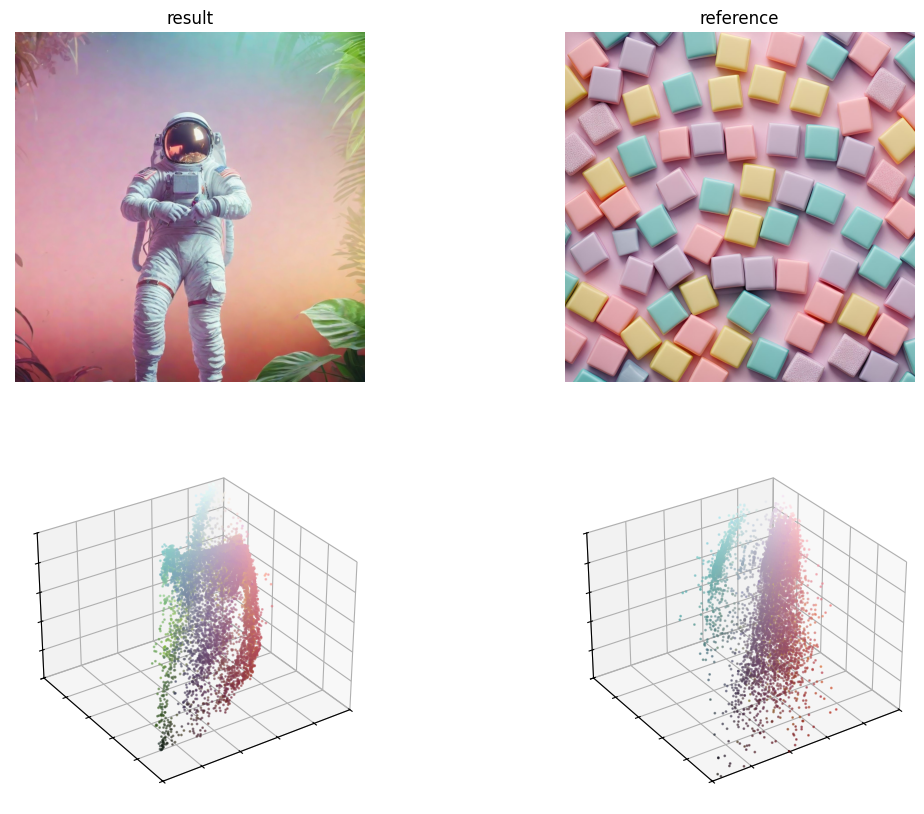

In [11]:
reference = Image.open("./assets/pastel.jpeg")

prompt = "Astronaut in a jungle, detailed, 8k"

# reload VAE an text encoders to gpu
pipe.to(device)

image = pipe(
    prompt=prompt,
    num_inference_steps=28,
    num_guided_steps=20,
    guidance_scale=5,
    sw_u_lr=0.01 * 10**4,
    height=768,
    width=768,
    sw_reference=reference,
).images[0]

titles = ["result", "reference"]
print_images([image, reference], titles=titles, with_density=True, points=10_000, s=1)
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

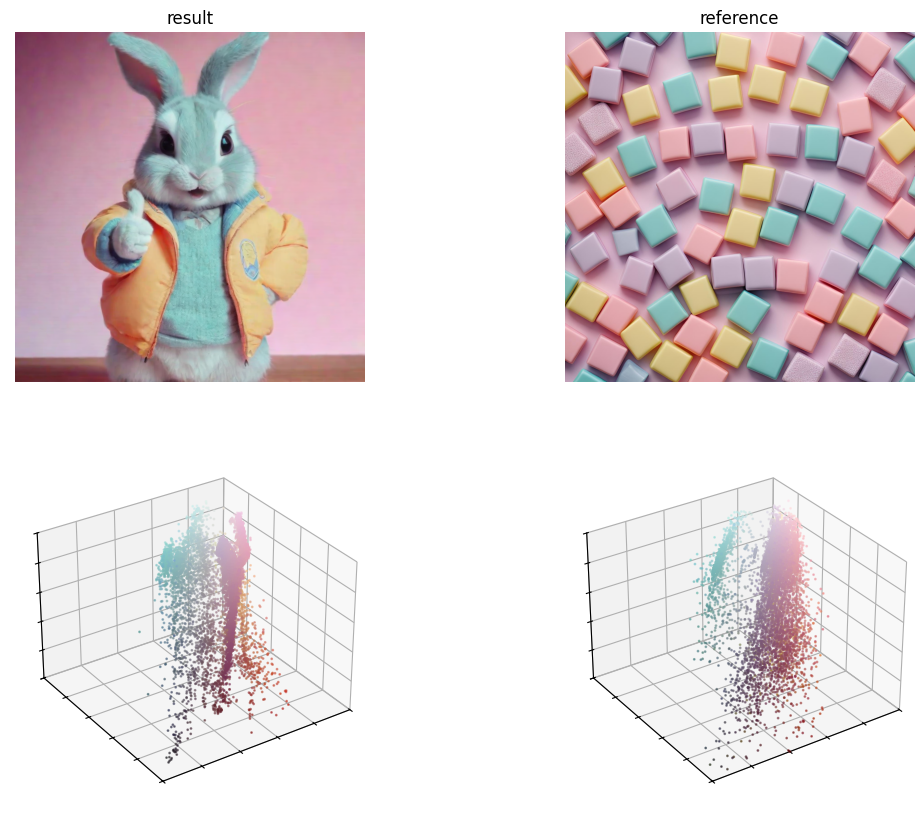

In [12]:
reference = Image.open("./assets/pastel.jpeg")

prompt = "A cinematic shot of a cute little rabbit wearing a jacket and doing a thumbs up"

# reload VAE an text encoders to gpu
pipe.to(device)

image = pipe(
    prompt=prompt,
    num_inference_steps=30,
    num_guided_steps=28,
    guidance_scale=5,
    sw_u_lr=0.01 * 10**4,
    height=768,
    width=768,
    sw_reference=reference,
).images[0]

print_images([image, reference], titles=titles, with_density=True, points=10_000, s=1)
plt.show()

In [16]:
reference = Image.open("./assets/gottingen.png")

prompt = "extremely detailed illustration of a steampunk train at the station, intricate details, perfect environment"

# reload VAE an text encoders to gpu
pipe.to(device)

image = pipe(
    prompt=prompt,
    num_inference_steps=30,
    num_guided_steps=28,
    guidance_scale=5,
    sw_u_lr=0.01 * 10**4,
    height=768,
    width=768,
    sw_reference=reference,
).images[0]

  0%|          | 0/30 [00:00<?, ?it/s]

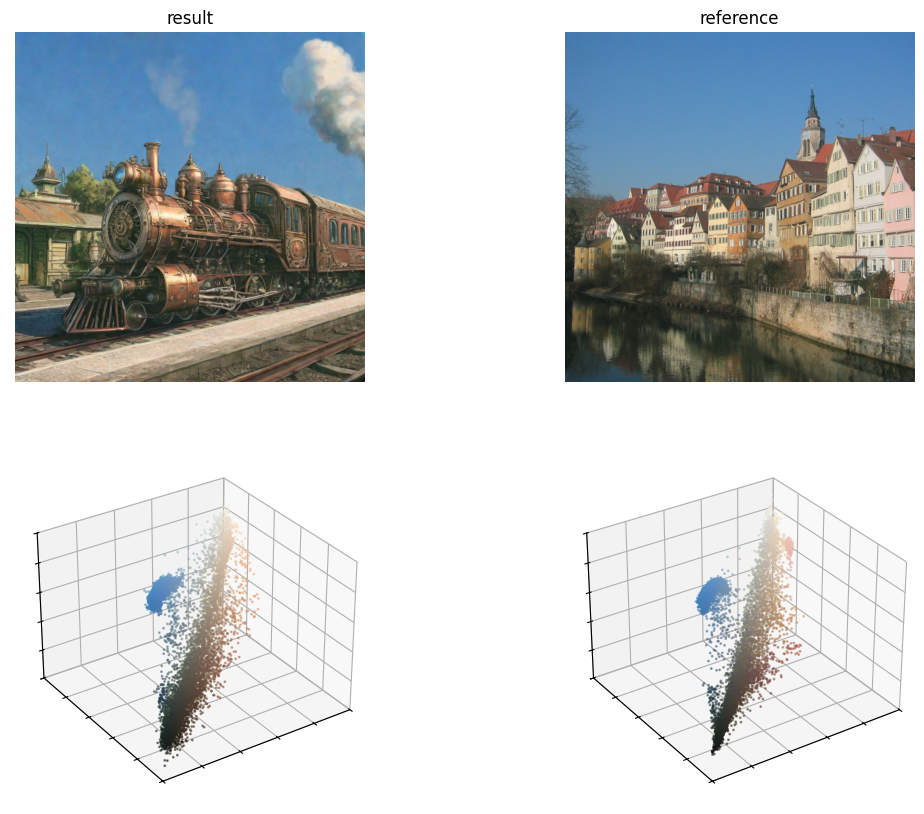

In [17]:
print_images([image, reference], titles=["result", "reference"], with_density=True, points=10_000, s=1)
plt.show()